# Initialize

In [1]:
#  Python Modules
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
# import requests
import json
import math
import itertools
from cycler import cycler
import plotly

import imp

# Custom Modules
import CensusData
import CovidData
import CovidFunctions
import CovidFunctionsPlotly

# imp.reload(CovidData)

# Covid Data    
https://covidtracking.com/api  
https://github.com/nytimes/covid-19-data  
https://www.apple.com/covid19/mobility  
https://www.google.com/covid19/mobility/  

## Download and Import Data

In [2]:
# Census Data
dfStateData = CensusData.StateData()

# Covid Data
dfCovid = CovidData.combine_data()

# State Level Events
dfEvents = pd.read_csv('Events.txt',parse_dates=[1])

# CDC Death Data
dfCDCdeaths = CovidData.cdc_death_data(dfStateData)

# Google and Apple mobility data
dfMobility = CovidData.mobility_data(dfStateData)

https://api.census.gov/data/2019/pep/population?get=POP&for=state:*
Population data API call result: 200 OK
https://api.census.gov/data/2010/dec/sf1?get=NAME&for=state:*
State name API call result: 200 OK
https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv
https://covidtracking.com/api/v1/states/daily.csv
Starting download CDC weekely death data...
Downloaded CDC weekly death data for every state from 2014-present.


C:\Users\Scott\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3249: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



Imported Apple and Google Mobility Reports


C:\Users\Scott\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




Created combined mobility report


In [13]:
imp.reload(CovidData)
dfMobility = CovidData.mobility_data(dfStateData)

Imported Apple and Google Mobility Reports
Collected Apple USA data
Collected Google USA data
Created combined mobility report


# Data Analysis

## Create USA Total Data

In [14]:
# Add USA to State Data with pop equal sum of all states
dfStateData.loc['00'] = {'State': 'USA', 'Population': pd.to_numeric(dfStateData['Population']).sum()}

# Add total reported CDC deaths for USA for each week
dfCDCusa = pd.DataFrame(dfCDCdeaths.groupby(['week', 'year'])['allcause'].sum()).reset_index()
dfCDCusa['state'] = 'USA'
dfCDCusa['FIPS'] = '00'
# dfCDCusa['weekendingdate'] = /add if needed later
dfCDCdeaths = dfCDCdeaths.append(dfCDCusa)

# For each day, sum columns of dfCovid
dfCovidUSA = pd.DataFrame(dfCovid.groupby('date').sum()).reset_index()
dfCovidUSA['fips'] = '00'
dfCovidUSA.set_index(['fips', 'date'], inplace = True)

dfCovid = dfCovid.append(dfCovidUSA)

## Merge Data

In [15]:
# Average Multiple 
col = dfCovid.loc[: , ["cases(NYT)","positive(CTP)"]]
dfCovid['positive_cases'] = col.mean(axis=1)

col = dfCovid.loc[: , ["deaths(NYT)","death(CTP)"]]
dfCovid['deaths'] = col.mean(axis=1)

# Covid Deaths by week number
dfCovid['week'] = [(index.isocalendar()[1] + index.isocalendar()[2] / 7) for index in dfCovid.index.get_level_values(1)]

print(dfCovid.columns.values)

['cases(NYT)' 'dataQualityGrade(CTP)' 'dateChecked(CTP)' 'death(CTP)'
 'deathIncrease(CTP)' 'deaths' 'deaths(NYT)' 'hospitalized(CTP)'
 'hospitalizedCumulative(CTP)' 'hospitalizedCurrently(CTP)'
 'hospitalizedIncrease(CTP)' 'inIcuCumulative(CTP)' 'inIcuCurrently(CTP)'
 'lastUpdateEt(CTP)' 'negative(CTP)' 'negativeIncrease(CTP)'
 'onVentilatorCumulative(CTP)' 'onVentilatorCurrently(CTP)' 'pending(CTP)'
 'positive(CTP)' 'positiveIncrease(CTP)' 'positive_cases' 'recovered(CTP)'
 'totalTestResults(CTP)' 'totalTestResultsIncrease(CTP)' 'week']


In [35]:
fipsList = dfCovid.index.get_level_values(0).unique().astype(int).sort_values().astype(str)
fipsList = fipsList.tolist()
fipsList[0] = '00'

firstDate = dfCovid.index.get_level_values(1).min()
currentDate = dfCovid.index.get_level_values(1).max()
plotDateRange = [firstDate, currentDate]    

## Deaths correlated to cases from previous days

In [16]:
shiftSearch = 30 # NUmber of days to correlate to

dfShiftCor = CovidFunctions.correlations(shiftSearch, dfCovid, fipsList)

Completed 30 days of case-death correlations and auto-correlations.


## State level analysis

In [46]:
imp.reload(CovidFunctions)
imp.reload(CovidFunctionsPlotly)

# Create plots for each state
for fips in fipsList:
    if int(fips) in [int(i) for i in dfStateData.index.tolist()]:
#         CovidFunctions.state_plot(dfCovid, dfShiftCor, dfStateData, dfEvents, fips, plotDateRange)
#         plt.close()
        CovidFunctionsPlotly.state_plot(dfCovid, dfShiftCor, dfStateData, dfEvents, 
                                        dfCDCdeaths, dfMobility, fips, plotDateRange)
    else:
        print('Did not create plot for FIPS = ' + fips)
        
# Update index.md
CovidFunctionsPlotly.githubIndex(dfStateData, fipsList)
        
print('Finished Creating all State plots')

Did not create plot for FIPS = 60
Did not create plot for FIPS = 66
Did not create plot for FIPS = 69
Did not create plot for FIPS = 78
Finished Creating all State plots


### Individual State

C:\Users\Scott\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



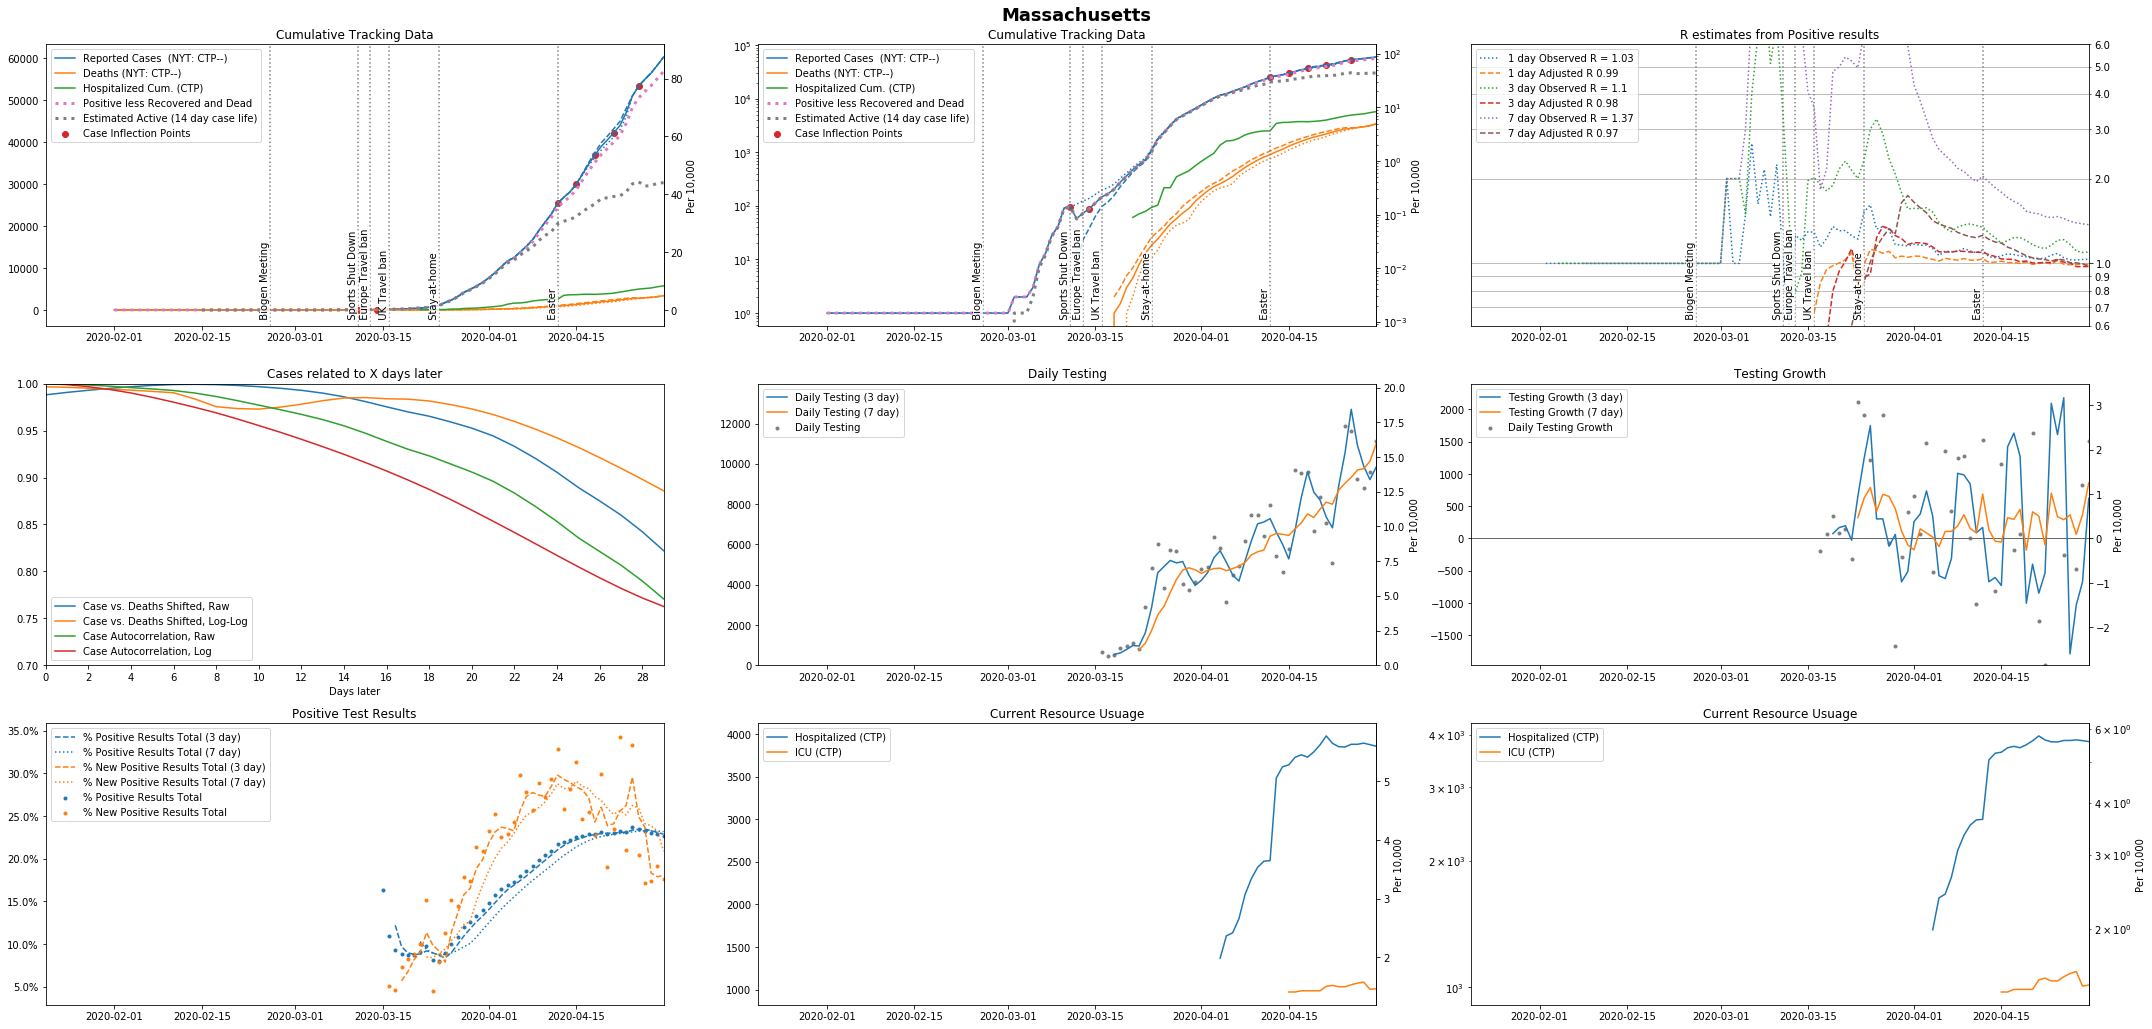

In [8]:
imp.reload(CovidFunctions)

fips = '25'
# plt.plot(dfCovid.loc[fips]['positive_cases'])

CovidFunctions.state_plot(dfCovid, dfShiftCor, dfStateData, dfEvents, fips, plotDateRange)


In [43]:
imp.reload(CovidFunctionsPlotly)
fips = '00'

CovidFunctionsPlotly.state_plot(dfCovid, dfShiftCor, dfStateData, dfEvents, dfCDCdeaths, dfMobility, fips, plotDateRange)

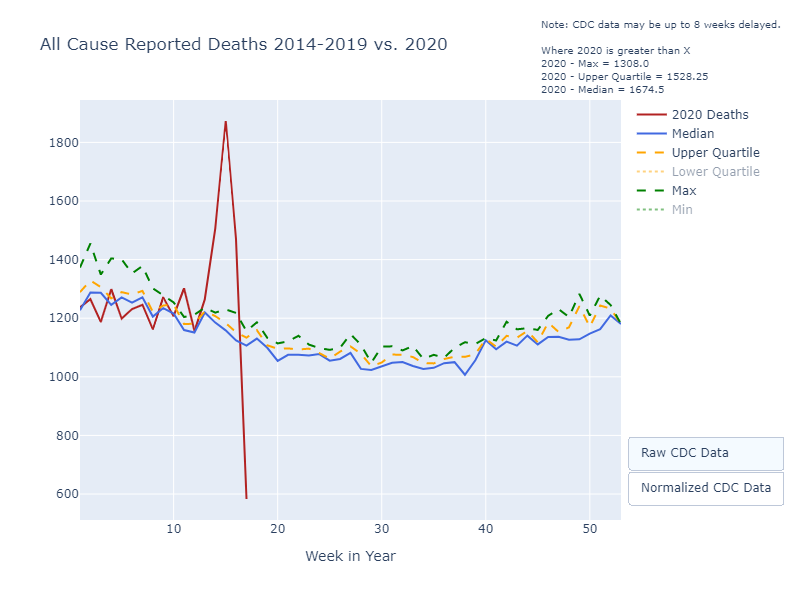

In [128]:
imp.reload(CovidFunctionsPlotly)
fips = '25'
fig = CovidFunctionsPlotly.cdc_deaths_plot(dfCDCdeaths, dfCovid, dfStateData, fips)
# fig = CovidFunctionsPlotly.event_markers(fig, dfEventsState)

fig.show()


In [28]:
# Update index.md
imp.reload(CovidFunctionsPlotly)
CovidFunctionsPlotly.githubIndex(dfStateData, fipsList)

In [10]:
imp.reload(CovidData)
dfCDCdeaths = CovidData.cdc_death_data(dfStateData)


Starting download CDC weekely death data...
Downloaded CDC weekly death data for every state from 2014-present.
